"Cyber-Physical Intrusion Detection System for Unmanned Aerial Vehicles,” in IEEE Transactions on Intelligent Transportation Systems (2023)

Here, we're gonna import both the datasets,
We have two datasets:
*   Cyber Dataset
*   Physical Dataset

We will have a feature **timestamp_c** for cyber dataset and **timestamp_p** for physical dataset.    
That'll be the common column for our combined dataset.


In [ ]:
import pandas as pd

# Load the uploaded datasets
cyber_dataset_path = '/content/Dataset_T-ITS.csv'
physical_dataset_path = '/content/Physical.xlsx'

# Reading the CSV dataset for cyber data
cyber_df = pd.read_csv(cyber_dataset_path)

# Reading the Excel file for physical data
physical_df = pd.read_excel(physical_dataset_path)

# Display basic info and head of each dataset for initial analysis
cyber_info = cyber_df.info(), cyber_df.head()
physical_info = physical_df.info(), physical_df.head()

cyber_info, physical_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33102 entries, 0 to 33101
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp_c             33102 non-null  float64
 1   frame.number            33102 non-null  int64  
 2   frame.len               33102 non-null  int64  
 3   frame.protocols         33102 non-null  int64  
 4   wlan.duration           33102 non-null  int64  
 5   wlan.ra                 33102 non-null  int64  
 6   wlan.ta                 33102 non-null  int64  
 7   wlan.da                 33102 non-null  int64  
 8   wlan.sa                 33102 non-null  int64  
 9   wlan.bssid              33102 non-null  int64  
 10  wlan.frag               33102 non-null  int64  
 11  wlan.seq                33102 non-null  int64  
 12  llc.type                33102 non-null  int64  
 13  ip.hdr_len              33102 non-null  int64  
 14  ip.len                  33102 non-null

((None,
     timestamp_c  frame.number  frame.len  frame.protocols  wlan.duration  \
  0  28105.97520            60         24                0              0   
  1  28105.97550            61         24                0              0   
  2  28107.09931            75        104                0              0   
  3  28114.78570           122         86                2             44   
  4  28114.88188           124         26                0             60   
  
     wlan.ra  wlan.ta  wlan.da  wlan.sa  wlan.bssid  ...  tcp.options  \
  0        1        1        1        1           0  ...            0   
  1        1        1        1        1           0  ...            0   
  2        4        1        4        1           0  ...            0   
  3        1        0        1        0           0  ...            1   
  4        1        0        1        0           0  ...            0   
  
     udp.srcport  udp.dstport  udp.length  data.data  data.len  wlan.fc.type  \
  0   

Above we explored both the datasets, cyber as well as physical.
We can see that both the datasets have that common feature
timestamp.  
Let's merge both the datasets on timestamp.

In [ ]:
timestamp_threshold = 1.0

# Merging datasets based on the closest match within the threshold
merged_data = pd.merge_asof(
    cyber_df.sort_values('timestamp_c'),
    physical_df.sort_values('timestamp_p'),
    left_on='timestamp_c',
    right_on='timestamp_p',
    tolerance=timestamp_threshold,
    direction='nearest'
)

# Drop any rows where no match was found (NaN entries in physical data)
merged_data.dropna(subset=['timestamp_p'], inplace=True)

# Display basic info of the merged dataset
merged_info = merged_data.info(), merged_data.head()

merged_info

<class 'pandas.core.frame.DataFrame'>
Index: 24783 entries, 51 to 33088
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp_c             24783 non-null  float64
 1   frame.number            24783 non-null  int64  
 2   frame.len               24783 non-null  int64  
 3   frame.protocols         24783 non-null  int64  
 4   wlan.duration           24783 non-null  int64  
 5   wlan.ra                 24783 non-null  int64  
 6   wlan.ta                 24783 non-null  int64  
 7   wlan.da                 24783 non-null  int64  
 8   wlan.sa                 24783 non-null  int64  
 9   wlan.bssid              24783 non-null  int64  
 10  wlan.frag               24783 non-null  int64  
 11  wlan.seq                24783 non-null  int64  
 12  llc.type                24783 non-null  int64  
 13  ip.hdr_len              24783 non-null  int64  
 14  ip.len                  24783 non-null  in

(None,
     timestamp_c  frame.number  frame.len  frame.protocols  wlan.duration  \
 51  16384.78599           624         26                0            162   
 52  16384.88865           629         26                0            162   
 53  16386.08393           645        227                3             44   
 54  16386.11719           647         26                0             60   
 55  16386.11721           649         26                0            162   
 
     wlan.ra  wlan.ta  wlan.da  wlan.sa  wlan.bssid  ...  yaw  temperature  \
 51        1        2        1        2           0  ...  0.0         61.0   
 52        1        2        1        2           0  ...  0.0         61.0   
 53        0        1        0        1           0  ...  0.0         61.0   
 54        1        0        1        0           0  ...  0.0         61.0   
 55        1        2        1        2           0  ...  0.0         61.0   
 
     distance  barometer  flight_time  battery  mp_distance

Above, We merged both the datasets on timestamp and we could have some common rows, the other rows, which did not match - We dropped (removed) them.

In [ ]:
merged_data.shape

(24783, 55)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select features and labels
# Combine network features and physical data, excluding timestamp columns and duplicate class columns
features = merged_data.drop(columns=['timestamp_c', 'timestamp_p', 'class_x', 'class_y'])
labels = merged_data['class_x']  # Assuming 'class_x' is the main label for now

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Display feature matrix summary and label distribution
features_summary = pd.DataFrame(features_scaled, columns=features.columns).describe()
label_distribution = labels.value_counts()

features_summary, label_distribution

(       frame.number     frame.len  frame.protocols  wlan.duration  \
 count  2.478300e+04  2.478300e+04     2.478300e+04   2.478300e+04   
 mean  -1.032141e-17 -3.669833e-17    -4.587291e-17   6.880937e-17   
 std    1.000020e+00  1.000020e+00     1.000020e+00   1.000020e+00   
 min   -1.581541e+00 -5.669026e-01    -5.774921e-01  -1.728289e+00   
 25%   -8.212640e-01 -5.403533e-01    -5.774921e-01  -1.249420e+00   
 50%   -1.821909e-01 -5.403533e-01    -5.774921e-01   7.777880e-01   
 75%    6.887298e-01  1.101053e-01     1.130994e+00   7.777880e-01   
 max    2.946145e+00  3.548244e+00     3.693723e+00   8.256748e-01   
 
             wlan.ra       wlan.ta       wlan.da       wlan.sa  wlan.bssid  \
 count  2.478300e+04  2.478300e+04  2.478300e+04  2.478300e+04     24783.0   
 mean   2.723704e-17 -1.488003e-16  2.723704e-17 -1.488003e-16         0.0   
 std    1.000020e+00  1.000020e+00  1.000020e+00  1.000020e+00         0.0   
 min   -9.211030e-01 -1.027559e+00 -9.211030e-01 -1.0275

Some of the values are extending into various ranges.   
So, we need to scale it down.
That'll will help us with having a closed range and it shall provide us a good result.

##Importing libraries

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [ ]:
merged_data.columns

Index(['timestamp_c', 'frame.number', 'frame.len', 'frame.protocols',
       'wlan.duration', 'wlan.ra', 'wlan.ta', 'wlan.da', 'wlan.sa',
       'wlan.bssid', 'wlan.frag', 'wlan.seq', 'llc.type', 'ip.hdr_len',
       'ip.len', 'ip.id', 'ip.flags', 'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq_raw', 'tcp.ack_raw',
       'tcp.hdr_len', 'tcp.flags', 'tcp.window_size', 'tcp.options',
       'udp.srcport', 'udp.dstport', 'udp.length', 'data.data', 'data.len',
       'wlan.fc.type', 'wlan.fc.subtype', 'time_since_last_packet', 'class_x',
       'timestamp_p', 'height', 'x_speed', 'y_speed', 'z_speed', 'pitch',
       'roll', 'yaw', 'temperature', 'distance', 'barometer', 'flight_time',
       'battery', 'mp_distance_x', 'mp_distance_y', 'mp_distance_z',
       'class_y'],
      dtype='object')

We can see above that, we have all the above given columns when we merged both the datasets.

##**SVM [Support Vector Machine]**:     
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.
The advantages of support vector machines are:



*   Effective in high dimensional spaces.
*   Still effective in cases where number of dimensions is greater than the number of samples.
*   Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
*   Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

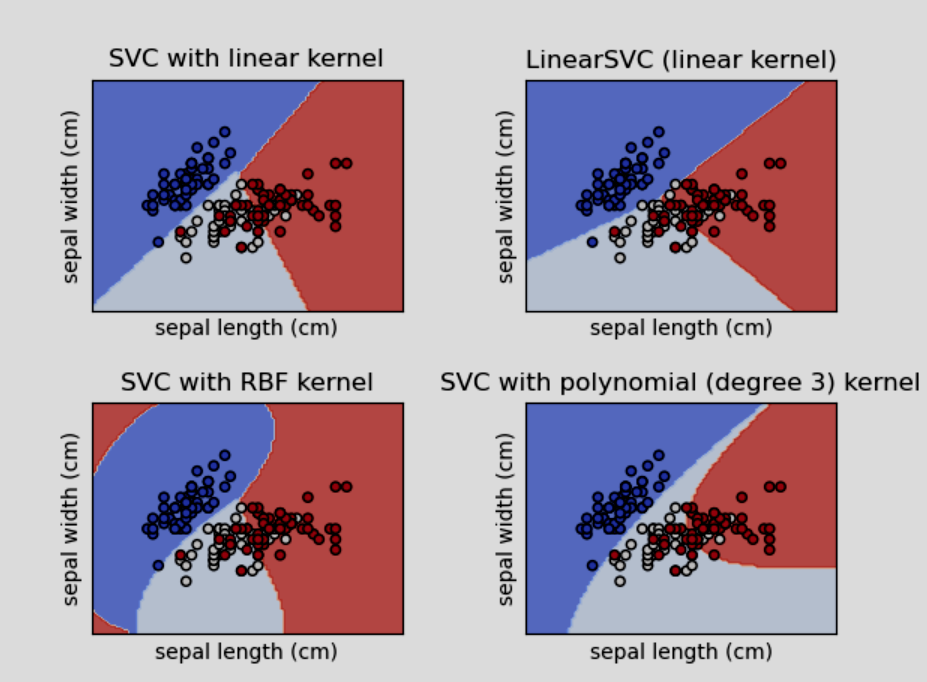

Kernel cache size: For SVC, SVR, NuSVC and NuSVR, the size of the kernel cache has a strong impact on run times for larger problems. If you have enough RAM available, it is recommended to set cache_size to a higher value than the default of 200(MB), such as 500(MB) or 1000(MB).

Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization.

Accuracy, precision, recall, and F1 score are all metrics used to evaluate the performance of machine learning models:                      

Accuracy:
*   The most common metric, which measures the proportion of correct predictions made by a model. It's calculated by dividing the number of true positives and true negatives by the total number of samples

Precision:
*   Measures the proportion of true positive predictions among all positive predictions made by the model. It's calculated by dividing the number of true positives by the sum of true positives and false positives.

Recall:
*   Measures the proportion of true positive predictions among all actual positive instances. It's calculated by dividing the number of true positives by the sum of true positives and false negatives

F1 score:
*   A harmonic mean of precision and recall that balances the importance of both metrics.       
It's calculated using the formula
`F1= (2* ((precision*recall)/(precision+recall)))`



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Create and train the SVM model
svm_model = SVC(kernel='linear', C=5)  # You can adjust kernel and C hyperparameters
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
svm_linear_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9941496873108735
Precision: 0.994193086464303
Recall: 0.9941496873108735
F1-Score: 0.9941554243495817

Classification Report:
               precision    recall  f1-score   support

  DoS attack       1.00      0.99      0.99      1998
      Replay       0.99      1.00      0.99      1802
      benign       1.00      1.00      1.00      1157

    accuracy                           0.99      4957
   macro avg       0.99      0.99      0.99      4957
weighted avg       0.99      0.99      0.99      4957



In [ ]:
svm_linear_train = svm_model.score(X_train, y_train)
svm_linear_test = svm_model.score(X_test, y_test)

print("Train Score:", svm_linear_train)
print("Test Score:", svm_linear_test)

Train Score: 0.9935942701503077
Test Score: 0.9941496873108735


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Create and train the SVM model
svm_model = SVC(kernel='poly', C=5)  # You can adjust kernel and C hyperparameters
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
svm_poly_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9816421222513617
Precision: 0.9816758941291673
Recall: 0.9816421222513617
F1-Score: 0.9816550098681447

Classification Report:
               precision    recall  f1-score   support

  DoS attack       0.98      0.98      0.98      1998
      Replay       0.97      0.98      0.98      1802
      benign       1.00      0.99      1.00      1157

    accuracy                           0.98      4957
   macro avg       0.98      0.98      0.98      4957
weighted avg       0.98      0.98      0.98      4957



In [ ]:
svm_poly_train = svm_model.score(X_train, y_train)
svm_poly_test = svm_model.score(X_test, y_test)

print("Train Score:", svm_poly_train)
print("Test Score:", svm_poly_train)

Train Score: 0.9836578230606274
Test Score: 0.9836578230606274


In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

Above we are encoding the categories into numerical form.
It is done because, it will help us predict in a much easy way in 1D-CNN, LSTM and other models.

##1D-CNN
A 1D Convolutional Layer (Conv1D) in deep learning is specifically designed for processing one-dimensional (1D) sequence data. This type of layer is particularly useful for tasks involving temporal sequences such as audio analysis, time-series forecasting, or natural language processing (NLP), where the data is inherently linear and sequential.



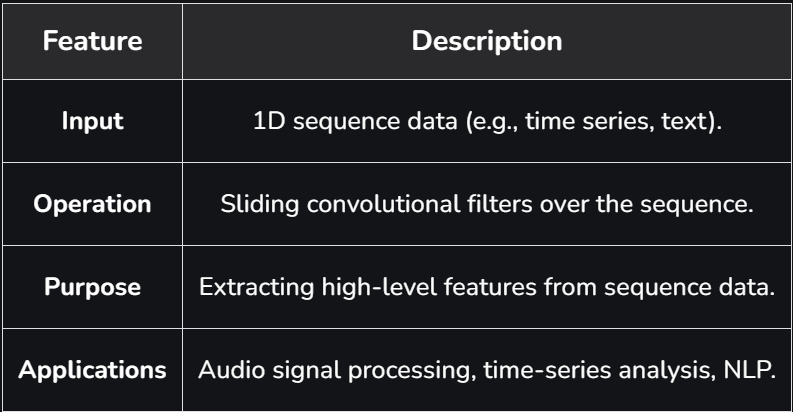


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import classification_report
import numpy as np

# Reshape the data for 1D CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the number of classes based on the unique values in y_train
num_classes = len(np.unique(y_train))

# Define the 1D CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Multi-class classification with softmax

# Compile the model using sparse categorical crossentropy
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_cnn, y_train, epochs=15, batch_size=32)

# Evaluate the model
loss, cnn_accuracy = model.evaluate(X_test_cnn, y_test)
print('Test accuracy:', cnn_accuracy)

# Make predictions on the test set
y_pred_prob = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to predicted class labels

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7927 - loss: 0.4540
Epoch 2/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9694 - loss: 0.0947
Epoch 3/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9895 - loss: 0.0371
Epoch 4/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9918 - loss: 0.0242
Epoch 5/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9923 - loss: 0.0223
Epoch 6/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9904 - loss: 0.0249
Epoch 7/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9932 - loss: 0.0169
Epoch 8/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9914 - loss: 0.0222
Epoch 9/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9935 - loss: 0.0171
Epoch 10/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9935 - loss: 0.0168
Epoch 11/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9942 - loss: 0.0140
Epoch 12/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy

In [ ]:
cnn_train_score = model.evaluate(X_train_cnn, y_train)[1]
cnn_test_score = model.evaluate(X_test_cnn, y_test)[1]

print("Conv1D Train Score:", cnn_train_score)
print("Conv1D Test Score:", cnn_test_score)

620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9932 - loss: 0.0162
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0256
Conv1D Train Score: 0.9924846291542053
Conv1D Test Score: 0.9925358295440674


##LSTM (Long Short Term Memory)
LSTM excels in sequence prediction tasks, capturing long-term dependencies. Ideal for time series, machine translation, and speech recognition due to order dependence.   
Long Short-Term Memory is an improved version of recurrent neural network.
  The LSTM architectures involves the memory cell which is controlled by three gates: the input gate, the forget gate, and the output gate.             
  These gates decide what information to add to, remove from, and output from the memory cell.
*   The input gate controls what information is added to the memory cell.
*   The forget gate controls what information is removed from the memory cell.
*   The output gate controls what information is output from the memory cell.





In [ ]:
# Reshape the input data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM model
model = Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_lstm, y_train, epochs=15, batch_size=32)

# Evaluate the model
loss, lstm_accuracy = model.evaluate(X_test_lstm, y_test)
print('Test accuracy:', lstm_accuracy)

# Make predictions on the test set
y_pred_prob = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


620/620 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.6013 - loss: 0.8313
Epoch 2/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7187 - loss: 0.6207
Epoch 3/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.8059 - loss: 0.4789
Epoch 4/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.8713 - loss: 0.3269
Epoch 5/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9005 - loss: 0.2539
Epoch 6/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.9257 - loss: 0.1999
Epoch 7/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.9385 - loss: 0.1651
Epoch 8/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9451 - loss: 0.1484
Epoch 9/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9529 - loss: 0.1261
Epoch 10/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9595 - loss: 0.1074
Epoch 11/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9608 - loss: 0.1042
Epoch 12/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
lstm_train = model.evaluate(X_train_lstm, y_train)
lstm_test = model.evaluate(X_test_lstm, y_test)

print("Train Score:", lstm_train)
print("Test Score:", lstm_test)

620/620 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9774 - loss: 0.0561
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9805 - loss: 0.0508
Train Score: [0.059234339743852615, 0.9760415554046631]
Test Score: [0.054417066276073456, 0.9776074290275574]


##FeedForward Neural Network Model
A **Feedforward Neural Network** (FNN) is a type of artificial neural network where connections between the nodes do not form cycles. This characteristic differentiates it from recurrent neural networks (RNNs). The network consists of an input layer, one or more hidden layers, and an output layer. Information flows in one direction—from input to output—hence the name "feedforward."

Structure of a Feedforward Neural Network
  
  **Input Layer**: The input layer consists of neurons that receive the input data. Each neuron in the input layer represents a feature of the input data.
  
 **Hidden Layers**: One or more hidden layers are placed between the input and output layers. These layers are responsible for learning the complex patterns in the data. Each neuron in a hidden layer applies a weighted sum of inputs followed by a non-linear activation function.
  
  **Output Layer**: The output layer provides the final output of the network. The number of neurons in this layer corresponds to the number of classes in a classification problem or the number of outputs in a regression problem.

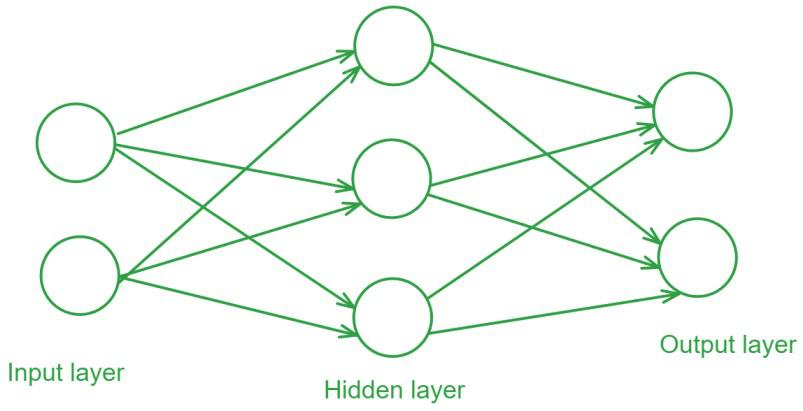


In [ ]:
X_train_fdd = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_fdd = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the Feedforward Neural Network model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_fdd.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_fdd, y_train, epochs=15, batch_size=32)

# Evaluate the model
loss, fdd_accuracy = model.evaluate(X_test_fdd, y_test)
print('Test accuracy:', fdd_accuracy)

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8282 - loss: 0.4109
Epoch 2/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9695 - loss: 0.0841
Epoch 3/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9827 - loss: 0.0487
Epoch 4/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9870 - loss: 0.0332
Epoch 5/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9887 - loss: 0.0301
Epoch 6/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9880 - loss: 0.0308
Epoch 7/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9902 - loss: 0.0231
Epoch 8/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9927 - loss: 0.0190
Epoch 9/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9879 - loss: 0.0260
Epoch 10/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9890 - loss: 0.0258
Epoch 11/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9931 - loss: 0.0166
Epoch 12/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [ ]:
fdd_train_score = model.evaluate(X_train_fdd, y_train)[1]
fdd_test_score = model.evaluate(X_test_fdd, y_test)[1]

print("FDD Train Score:", fdd_train_score)
print("FDD Test Score:", fdd_test_score)

print(model.metrics_names)

620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9917 - loss: 0.0172
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9889 - loss: 0.0200
FDD Train Score: 0.9913245439529419
FDD Test Score: 0.9901149868965149
['loss', 'compile_metrics']


##XGBoost
XGBoost is an optimized distributed gradient boosting library designed for efficient and scalable training of machine learning models. It is an ensemble learning method that combines the predictions of multiple weak models to produce a stronger prediction.  
XGBoost stands for “Extreme Gradient Boosting” and it has become one of the most popular and widely used machine learning algorithms due to its ability to handle large datasets and its ability to achieve state-of-the-art performance in many machine learning tasks such as classification and regression.

One of the key features of XGBoost is its **efficient handling of missing values**, which allows it to handle real-world data with missing values without requiring significant pre-processing. Additionally, XGBoost has built-in support for **parallel processing**, making it possible to train models on **large datasets in a reasonable amount of time**.

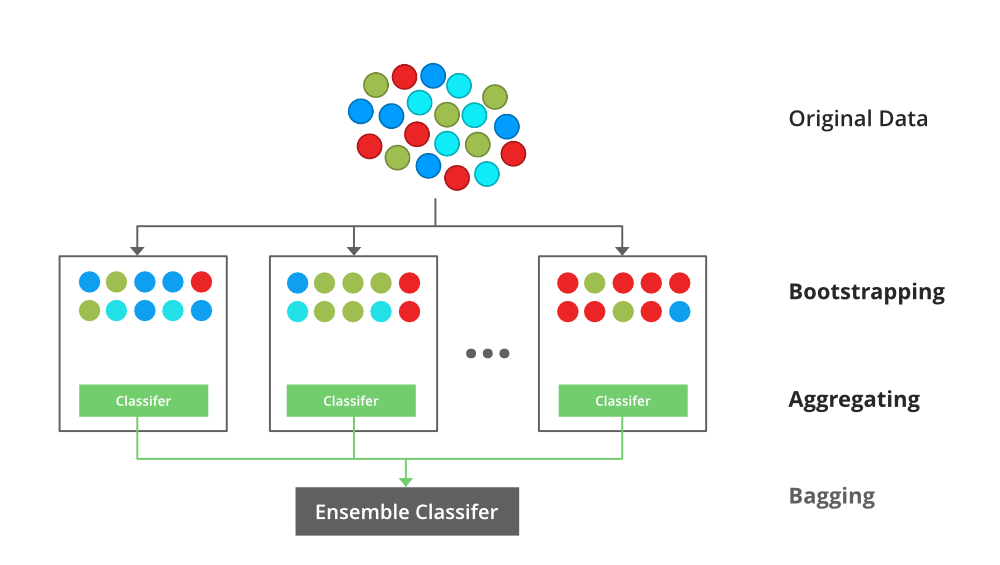

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate and print metrics
xg_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", xg_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9909219285858382
Precision: 0.9909217854179964
Recall: 0.9909219285858382
F1-Score: 0.9909218044030489

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1998
           1       0.99      0.99      0.99      1802
           2       1.00      1.00      1.00      1157

    accuracy                           0.99      4957
   macro avg       0.99      0.99      0.99      4957
weighted avg       0.99      0.99      0.99      4957



In [ ]:
xgb_train = xgb_model.score(X_train, y_train)
xgb_test = xgb_model.score(X_test, y_test)

print("Train Score:", xgb_train)
print("Test Score:", xgb_test)

Train Score: 0.9960153334005851
Test Score: 0.9909219285858382


##RandomForest Classifier Model
The Random forest classifier creates a set of decision trees from a randomly selected subset of the training set. It is a set of decision trees (DT) from a randomly selected subset of the training set and then It collects the votes from different decision trees to decide the final prediction.   

Each decision tree in the random forest is constructed using a subset of the training data and a random subset of features introducing diversity among the trees, making the model more robust and less prone to overfitting.


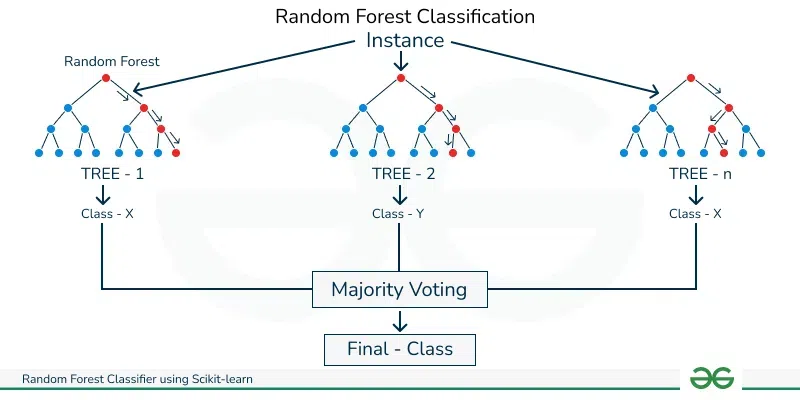

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate and print metrics
rfr_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", rfr_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9901149889045794
Precision: 0.9901078091702299
Recall: 0.9901149889045794
F1-Score: 0.9901104313524477

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1998
           1       0.99      0.99      0.99      1802
           2       1.00      1.00      1.00      1157

    accuracy                           0.99      4957
   macro avg       0.99      0.99      0.99      4957
weighted avg       0.99      0.99      0.99      4957



In [ ]:
rf_train = rf_model.score(X_train, y_train)
rf_test = rf_model.score(X_test, y_test)

print("Train Score:", rf_train)
print("Test Score:", rf_test)

Train Score: 0.9960153334005851
Test Score: 0.9901149889045794


##CatBoost Model
CatBoost stands for “Categorical Boosting.” It's like having a super-smart assistant who specializes in handling 'categorical' data.




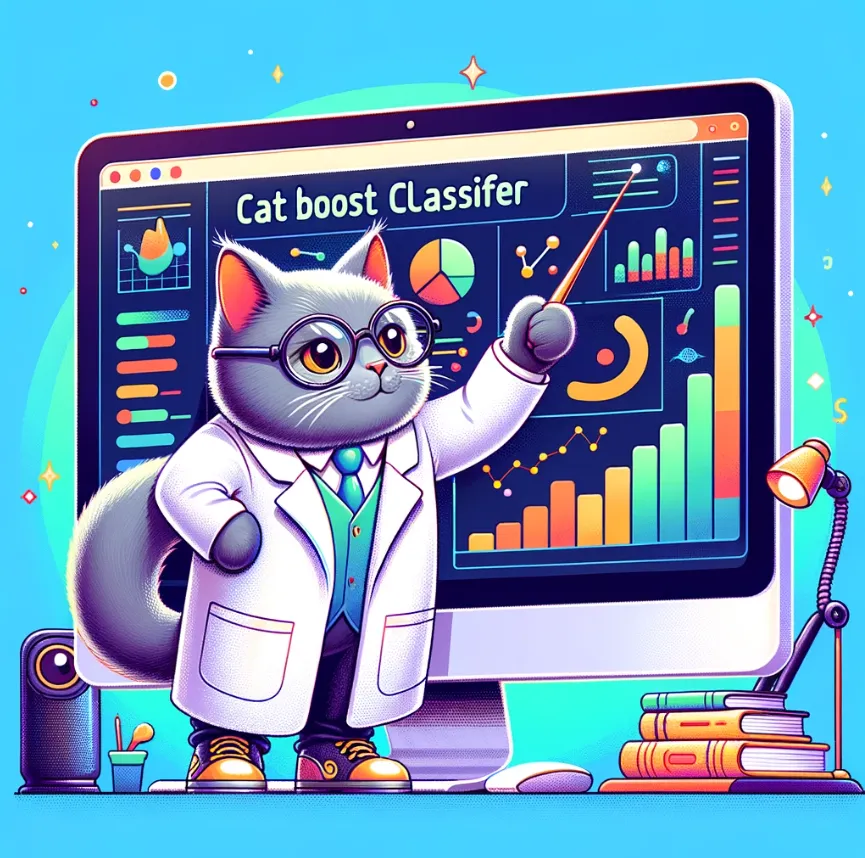

In [ ]:
!pip install catboost

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Create and train the CatBoost model
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='MultiClass')
catboost_model.fit(X_train, y_train, verbose=False)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Calculate and print metrics
cb_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", cb_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00
Accuracy: 0.993746217470244
Precision: 0.9937480729464414
Recall: 0.993746217470244
F1-Score: 0.9937467178168341

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1998
           1       0.99      0.99      0.99      1802
           2       1.00      1.00      1.00      1157

    accuracy                           0.99      4957
   macro avg       0.99      0.99      0.99      4957
weighted avg       0.99      0.99      0.99      4957



In [ ]:
cb_train = catboost_model.score(X_train, y_train)
cb_test = catboost_model.score(X_test, y_test)

print("Train Score:", cb_train)
print("Test Score:", cb_test)

Train Score: 0.99460304650459
Test Score: 0.993746217470244


##AdaBoost Model
It is a part of the advanced ensemble learning models family and follows the way that boosting learning algorithm

Step 1: When the algorithm is given data, it starts by Assigning equal weights to all training examples in the dataset. These weights represent the importance of each sample during the training process.

Step 2: Here, this algorithm iterates with a few algorithms for a specified number of iterations (or until a stopping criterion is met). The algorithm trains a weak classifier on the training data. Here the weak classifier can be considered a model that performs slightly better than random guessing, such as a decision stump (a one-level decision tree).

Step 3: During each iteration, the algorithm trains the weak classifier on given training data with the current sample weights. The weak classifier aims to minimize the classification error, weighted by the sample weights.

Step 4: After training the weak classifier, the algorithm calculates classifier weight based on the errors of the weak classifier. A weak classifier with a lower error receives a higher weight.

Step 4: Once the calculation of weight completes, the algorithm updates sample weights, and the algorithm gives assigns higher weights to misclassified examples so that more importance in subsequent iterations can be given.

Step 5: After updating the sample weights, they are normalized so that they sum up to 1 and Combine the predictions of all weak classifiers using a weighted majority vote. The weights of the weak classifiers are considered when making the final prediction.

Step 6: Finally, Steps 2-5 are repeated for the specified number of iterations (or until the stopping criterion is met), with the sample weights updated at each iteration. The final prediction is obtained by aggregating the predictions of all weak classifiers based on their weights.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create and train the AdaBoost model
ada_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42
)
ada_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ada_model.predict(X_test)

# Calculate and print metrics
ada_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", ada_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9669154730683881
Precision: 0.9669648491475104
Recall: 0.9669154730683881
F1-Score: 0.9668711378347956

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1998
           1       0.96      0.95      0.95      1802
           2       0.96      0.99      0.97      1157

    accuracy                           0.97      4957
   macro avg       0.97      0.97      0.97      4957
weighted avg       0.97      0.97      0.97      4957



In [ ]:
ab_train = ada_model.score(X_train, y_train)
ab_test = ada_model.score(X_test, y_test)

print("Train Score:", ab_train)
print("Test Score:", ab_test)

Train Score: 0.9653989710481187
Test Score: 0.9669154730683881


##Summary

In [ ]:
from tabulate import tabulate

# Create a list of dictionaries to store the results
data = [["SVM Linear",svm_linear_train, svm_linear_test,svm_linear_accuracy],
    ["SVM Poly",svm_poly_train, svm_poly_test,svm_poly_accuracy ],
    ["Conv1D", cnn_train_score, cnn_test_score,cnn_accuracy],
    ["LSTM", lstm_train, lstm_test, lstm_accuracy],
    ["Feedforward", fdd_train_score, fdd_test_score, fdd_accuracy],
    ["XGBoost", xgb_train, xgb_test, xg_accuracy],
    ["Random Forest", rf_train, rf_test, rfr_accuracy],
    ["CatBoost", cb_train, cb_test, cb_accuracy],
    ["AdaBoost", ab_train, ab_test , ada_accuracy]]

# Create a table using tabulate
col_names = ["Model", "Train Score", "Test Score", "Accuracy"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤════════════════════════════════════════════╤════════════════════════════════════════════╤════════════╕
│ Model         │ Train Score                                │ Test Score                                 │   Accuracy │
╞═══════════════╪════════════════════════════════════════════╪════════════════════════════════════════════╪════════════╡
│ SVM Linear    │ 0.9935942701503077                         │ 0.9941496873108735                         │   0.99415  │
├───────────────┼────────────────────────────────────────────┼────────────────────────────────────────────┼────────────┤
│ SVM Poly      │ 0.9836578230606274                         │ 0.9816421222513617                         │   0.981642 │
├───────────────┼────────────────────────────────────────────┼────────────────────────────────────────────┼────────────┤
│ Conv1D        │ 0.9924846291542053                         │ 0.9925358295440674                         │   0.992536 │
├───────────────┼───────────────